In [29]:
import folium
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

# Load the NYPD complaints data
data = pd.read_csv("../data/nypd_complaints_precinct_76.csv")

# Filter for records where LAW_CAT_CD is 'FELONY' and OFNS_DESC is 'FELONY ASSAULT'
felony_data = data[(data['LAW_CAT_CD'] == 'FELONY') & (data['OFNS_DESC'] == 'FELONY ASSAULT')].copy()

# Function to snap to grid
GRID_SIZE = 0.001  # e.g., ~100 meters depending on location

def snap_to_grid(coordinate):
    """Snap a latitude or longitude to the nearest grid coordinate"""
    return round(coordinate / GRID_SIZE) * GRID_SIZE

# Snap felony data to grid
felony_data['GRID_LAT'] = felony_data['Latitude'].apply(snap_to_grid)
felony_data['GRID_LONG'] = felony_data['Longitude'].apply(snap_to_grid)

# Group by grid location
grouped_felonies = felony_data.groupby(['GRID_LAT', 'GRID_LONG']).size().reset_index(name='counts')

# Filter out locations with more than N incidents in order to skip reports at the precinct
grouped_felonies = grouped_felonies[grouped_felonies['counts'] <= 20]

# Create the map
m = folium.Map(location=[felony_data['Latitude'].mean(), felony_data['Longitude'].mean()], zoom_start=15, tiles='CartoDB Positron')

# Calculate max count for scaling purposes
max_count = grouped_felonies['counts'].max()

# Adding circles to the map
for idx, row in grouped_felonies.iterrows():
    # Scale the radius according to count
    radius = (row['counts'] / max_count) * 20  # This scales the highest count to a radius of 20; adjust as necessary
    
    folium.CircleMarker(
        location=(row['GRID_LAT'], row['GRID_LONG']),
        radius=radius,
        fill=True,
        fill_opacity=0.7,
        color='red',
        fill_color='red'
    ).add_to(m)

# Display the map
m

# Save the map to an HTML file if needed
m.save('nypd_complaints.html')

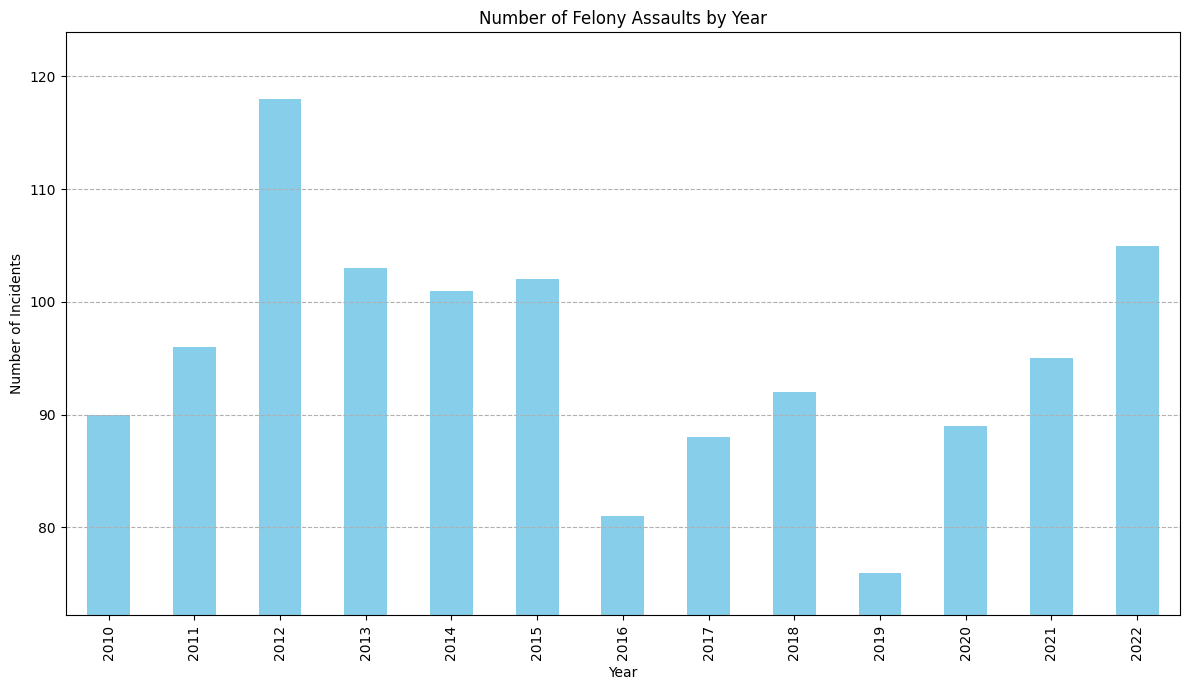

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the dataset
data = pd.read_csv("../data/nypd_felony_assaults.csv")

# 2. Extract the year from the RPT_DT column
data['YEAR'] = pd.to_datetime(data['RPT_DT']).dt.year

# 3. Group by the year and count the number of incidents
yearly_counts = data.groupby('YEAR').size()

# 4. Determine y-axis limits
lower_limit = yearly_counts.min() - 0.05 * yearly_counts.min()
upper_limit = yearly_counts.max() + 0.05 * yearly_counts.max()

# 5. Plot the counts
plt.figure(figsize=(12, 7))
yearly_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Felony Assaults by Year")
plt.ylabel("Number of Incidents")
plt.xlabel("Year")
plt.ylim(lower_limit, upper_limit)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()